#  Прогнозирование заказов такси

### Описание проекта

Компания такси собирается оптимизировать работу водителей в часы пик. Необходимо спрогнозировать количество заказов такси на следующий час.

**Цель проекта:**

* Построить модель для предсказания количества заказов такси на следующий час.
* Значение метрики RMSE на тестовой выборке должно быть не больше 48.

**Описание данных:**

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `'num_orders'` (от англ. number of orders, «число заказов»).

### Структура проекта:

1. Подготовка данных
2. Анализ данных
3. Обучение моделей
4. Тестирование модели
5. Итоги исследования

## 1. Подготовка данных

In [ ]:
# импортируем необходимые библиотеки
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error

In [6]:
# загружаем датасет
if os.path.exists(f'taxi.csv'):
    df = pd.read_csv(f'taxi.csv', 
                     index_col=[0], 
                     parse_dates=[0]).sort_index()
elif os.path.exists(f'/datasets/taxi.csv'):
    df = pd.read_csv(f'/datasets/taxi.csv', 
                     index_col=[0], 
                     parse_dates=[0]).sort_index()
else:
    print(f'Something is wrong')

In [7]:
# выводим таблицу и инфо о ней
display(df)
df.info()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Выполним ресемплирование данных по одному часу. Поскольку предсказываем количество заказов такси на следующий час, аггрегируем суммы значений.

In [8]:
df = df.resample('1H').sum()

## 2. Анализ данных

Разложим данные на три составляющие: тренд, сезонность и остаток. Построим графики последнего месяца временного ряда и проанализируем данные.

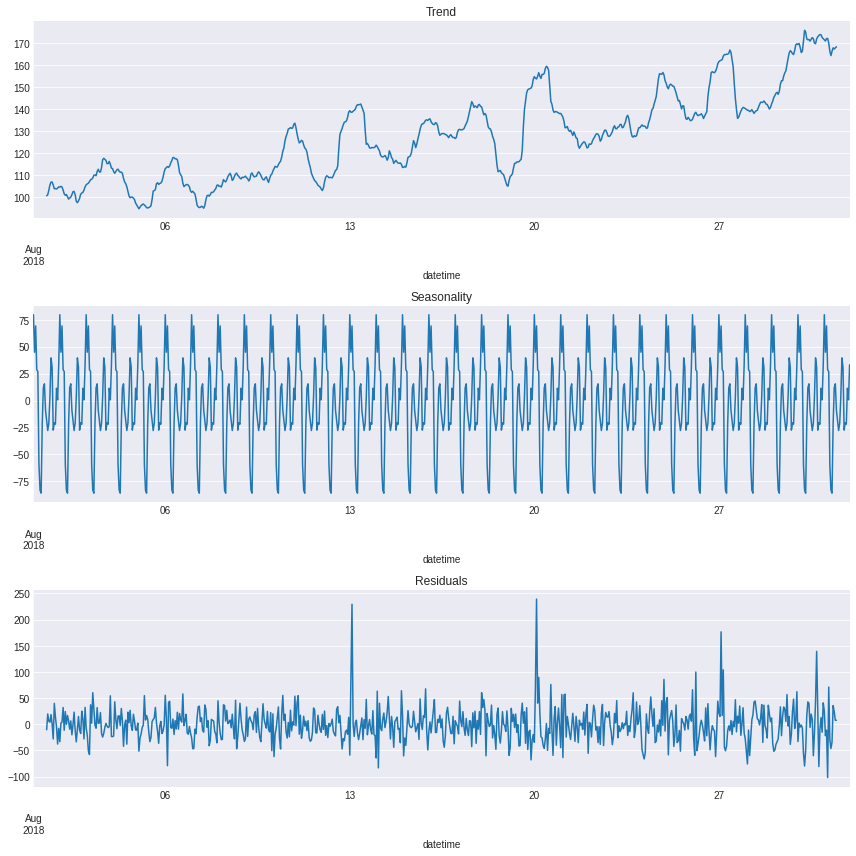

In [9]:
decomposed = seasonal_decompose(df['2018-08':'2018-08'])

plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(12, 12))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

* Распределение сезонной части выглядит статическим в интервале суток. Ночью такси почти не заказывают, пик ближе к вечеру.
* Случайная часть также имеет постоянной среднее значение, но периодически возникают большие всплески (объясняются повышенным спросом на такси по выходным и праздникам)
* Тренд показывает линейный рост количества заказов со временем.

## 3. Обучение моделей

В качестве baseline модели будем предсказывать новые значения предыдущими либо по среднему значению. Проверим оба варианта.

In [10]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()
pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[-1]
rmse_base =  mean_squared_error(test['num_orders'], pred_previous) ** 0.5
print("RMSE модели по предыдущему значению:", round(rmse_base, 3))

RMSE модели по предыдущему значению: 58.856


In [11]:
pred_mean = np.ones(test.shape) * train['num_orders'].mean()
print("RMSE модели по среднему значению:", mean_squared_error(test['num_orders'], pred_mean) ** 0.5)

RMSE модели по среднему значению: 84.74414402014742


Предсказания по предыдущему значению показывают лучший результат. Возьмём их в качестве baseline.

Напишем функцию для создания обучающих признаков. Создадим признаки `day`, `dayofweek`. А также признаки для скользящего среднего `rolling_mean` (с размером окна `rolling_mean_size`), и `lag_i` для признаков отстающего значения.

In [12]:
def make_features(data, max_lag, rolling_mean_size):
    data = data.copy()
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data

In [13]:
data = make_features(df, 50, 50)

Для начала обучим **Линейную регрессию**. Разделим данные в соотношении 9:1 (10% тестовой выборки).

In [15]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

In [16]:
X_train = train.drop('num_orders', axis = 1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis = 1)
y_test = test['num_orders']

lr = LinearRegression()
lr.fit(X_train, y_train)
preds_train = lr.predict(X_train)
print("RMSE на обучающей выборке:", mean_squared_error(y_train, preds_train, squared=False))

preds_test = lr.predict(X_test)
print("RMSE на тестовой выборке: ", mean_squared_error(y_test, preds_test, squared=False))

RMSE на обучающей выборке: 22.219674538126633
RMSE на тестовой выборке:  37.305520431143215


Подберём параметры для линейной регрессии более точно.

In [13]:
%%time

best_lag_lr = 0
best_roll_size_lr = 0
best_rmse_lr = 48

for lag in range(80, 101, 2):
    for roll_size in range(40, 81, 2):

        data = make_features(df, lag, roll_size)
        train, test = train_test_split(data, shuffle=False, test_size=0.1)
        train = train.dropna()
        X_train = train.drop('num_orders', axis = 1)
        y_train = train['num_orders']
        X_test = test.drop('num_orders', axis = 1)
        y_test = test['num_orders']

        lr = LinearRegression()
        lr.fit(X_train, y_train)

        preds_test = lr.predict(X_test)
        rmse = mean_squared_error(y_test, preds_test, squared=False)
        if rmse < best_rmse_lr:
            best_rmse_lr = rmse
            best_lag_lr = lag
            best_roll_size_lr = roll_size
            
print(f"""RMSE на тестовой выборке: {best_rmse_lr}, 
максимальное смещение {best_lag_lr}, 
размер скользящего окна {best_roll_size_lr}""")

RMSE на тестовой выборке: 39.79310444950342, 
максимальное смещение 100, 
размер скользящего окна 52
CPU times: total: 45.6 s
Wall time: 39.3 s


Попробуем обучить модель **Lasso**.

In [14]:
%%time

best_lag_ls = 0
best_roll_size_ls = 0
best_alpha_ls = 0
best_rmse_ls = 48

for lag in range(80, 101, 2):
    for roll_size in range(40, 81, 2):
        for alpha in np.arange(0.1, 1, 0.2):
            
            data = make_features(df, lag, roll_size)
            train, test = train_test_split(data, shuffle=False, test_size=0.1)
            train = train.dropna()
            X_train = train.drop('num_orders', axis = 1)
            y_train = train['num_orders']
            X_test = test.drop('num_orders', axis = 1)
            y_test = test['num_orders']
            
            ls = Lasso(alpha=alpha)
            ls.fit(X_train, y_train)
            
            preds_test = ls.predict(X_test)
            rmse = mean_squared_error(y_test, preds_test, squared=False)
            if rmse < best_rmse_ls:
                best_rmse_ls = rmse
                best_lag_ls = lag
                best_roll_size_ls = roll_size
                best_alpha_ls = alpha

print(f"""RMSE на тестовой выборке: {best_rmse_ls}, 
максимальное смещение {best_lag_ls}, 
размер скользящего окна {best_roll_size_ls},
коэффициент регуляризации: {best_alpha_ls}""")

RMSE на тестовой выборке: 39.78568030332225, 
максимальное смещение 100, 
размер скользящего окна 46,
коэффициент регуляризации: 0.9000000000000001
CPU times: total: 8min 21s
Wall time: 8min 18s


## 4. Тестирование модели

* Проверка на тестовой выборке была проведена в предыдущем пункте и выявила лучшую модель для предсказаний **Lasso** (RMSE=39.786).
* Для предсказаний модели **Lasso** с параметром регуляризации `alpha=0.9` построим графики зависимостей целевого признака и предсказаний от времени. Проверим, в какие моменты модель была более точной и менее точной. Для наглядности графика построим последние 14 дней.

In [15]:
data = make_features(df, 100, 46)
train, test = train_test_split(data, shuffle=False, test_size=0.2)
train = train.dropna()
X_train = train.drop('num_orders', axis = 1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis = 1)
y_test = test['num_orders']

lasso = Lasso(alpha=0.9)
lasso.fit(X_train, y_train)
preds_test = pd.Series(lasso.predict(X_test), index = y_test.index, name='preds')

<AxesSubplot:xlabel='datetime', ylabel='num_orders'>

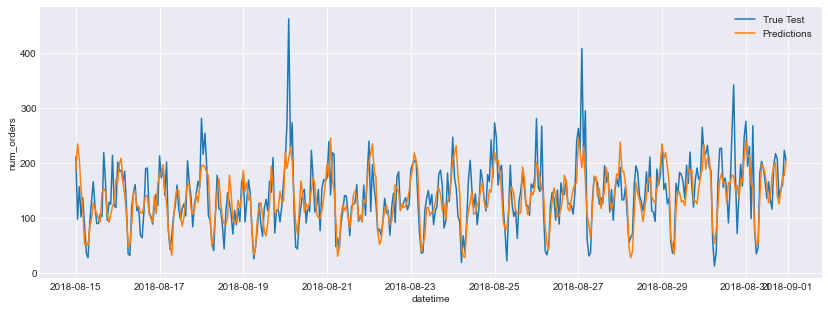

In [16]:
df_preds = pd.concat([y_test, preds_test], axis=1)

plt.figure(figsize=(14, 5))
sns.lineplot(x=df_preds['2018-08-15':].index, y=df_preds['2018-08-15':]['num_orders'], label='True Test')
sns.lineplot(x=df_preds['2018-08-15':].index, y=df_preds['2018-08-15':]['preds'], label='Predictions')

## 5. Итоги исследования

* Обе модели показали похожий результат по RMSE.
* Максимальное смещение ограничено значением 100 ввиду сложности модели. Дальше показатель RMSE не сильно растёт.
* Наилучшие результат даёт скользящее окно размером ~40-50 часов.
* С помощью модели Lasso удалось уменьшить RMSE на 43% относительно baseline.
* По графику видно, что модель достаточно точно определяет ежедневно повторяющиеся тестовые данные. Однако редкие пики в данных предсказать не может.